Import the package and load the data

In [2]:
import itertools
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

vcounts = pd.read_csv('video_count.csv')


vcounts['date'] = pd.to_datetime(vcounts['date'])
vcounts.rename(columns={'count':'view_count'},inplace = True)
vcounts.head(5)

,video_id,view_count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08


In [3]:
vfeatures = pd.read_csv('video_features.csv',index_col = 'video_id')
vfeatures.rename(columns = {'video_length':'length',
                            'video_language':'language',
                            'video_upload_date':'upload_date',
                           'video_quality':'quality'},inplace = True)
vfeatures['upload_date'] = pd.to_datetime(vfeatures['upload_date'])
vfeatures.quality = vfeatures.quality.apply(lambda x: int(x[:-1]))
vfeatures.head(5)

,length,language,upload_date,quality
video_id,,,,
2374,1760,Cn,2014-12-06,480
1897,489,Cn,2014-12-10,720
2386,1273,Es,2014-12-05,480
2912,986,Es,2014-12-10,240
2432,1050,Other,2014-12-10,480


In [4]:
vfeatures.upload_date.describe()

count                    2785
unique                     23
top       2014-12-10 00:00:00
freq                      242
first     2014-12-02 00:00:00
last      2014-12-24 00:00:00
Name: upload_date, dtype: object

Extract the feature and find the pattern

In [5]:
def extract_counts(df):
        """
    input:
        DataFrame of a certain video (same video_id)
    output:
        25th,50th,75th,mean of that video's view_count
        25th,50th,75th,mean of that video's view_count's change rate
    """
        counts = df.sort_values(by='date',).view_count.astype(np.float)
        qs = [25,50,75]
        count_percentiles = np.percentile(counts,qs)
        d = {'cnt_{}th'.format(p):q for p,q in itertools.zip_longest(qs,count_percentiles)}
        d['cnt_mean'] = counts.mean()
    
    #calculate the rate
        count_prev = counts.iloc[:-1]
        count_current = counts.iloc[1:]
        rates = count_current.values/count_prev.values
    
        rates_percentiles = np.percentile(rates,qs)
        for p,q in itertools.zip_longest(qs,rates_percentiles):
            d['rnt_{}th'.format(p)] = q
        d['rnt_mean'] = rates.mean()
    
        return pd.Series(d)
         

In [6]:
v_stat = vcounts.groupby('video_id').apply(extract_counts)
v_stat.head(10)

,cnt_25th,cnt_50th,cnt_75th,cnt_mean,rnt_25th,rnt_50th,rnt_75th,rnt_mean
video_id,,,,,,,,
1,41099.0,65907.0,96335.0,7.063560e+04,0.813619,0.848616,0.932023,0.872563
2,1673415.5,1718352.0,1782226.5,1.737141e+06,0.938541,0.956124,1.030687,0.985816
3,2132336.5,2247587.0,2436222.5,2.292781e+06,0.971707,0.998932,1.056393,1.008923
4,2611162.0,2719547.0,2880268.5,2.740392e+06,0.972875,1.001606,1.050860,1.011310
5,255574.5,388594.0,609508.0,4.479973e+05,0.822568,0.866553,0.987271,0.888189
6,29922.0,58520.0,116782.0,7.314840e+04,0.800074,0.869429,0.936239,0.866714
7,138297.5,236740.0,366209.0,2.528385e+05,0.764731,0.876471,0.962816,0.865547
8,1950028.5,2042499.0,2154066.5,2.049360e+06,0.965805,1.009304,1.046501,1.004013
9,316.5,328.0,338.5,3.267333e+02,0.969211,1.018093,1.066753,1.014110


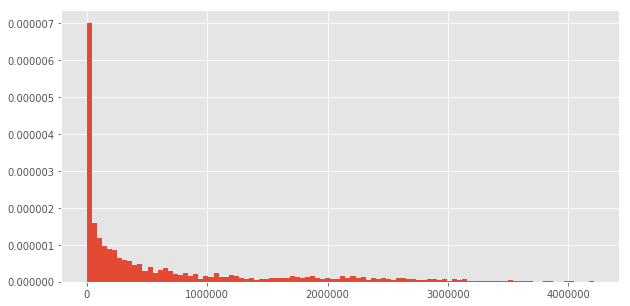

In [7]:
plt.figure(figsize = (10,5))
_ = plt.hist(v_stat.cnt_mean,bins = 100,normed = True)
plt.show()

In [8]:
count_cutoff = 1000000
(v_stat.cnt_mean>count_cutoff).mean()

0.22621184919210055


there are 23% of the videos which can have average daily view_count higher than 100,0000. so 100,0000 counts cpuld be a goog choice as a cutoff to decide the video is popular or not.


We can also plot the rates distribution to decide the video's trending status

In [9]:
v_stat['is_popular'] = v_stat.cnt_mean >= 1000000


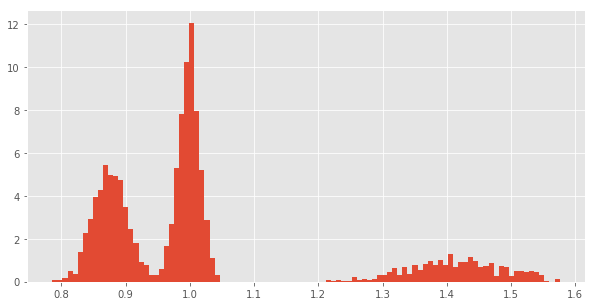

In [10]:
plt.figure(figsize = (10,5))
_ = plt.hist(v_stat.rnt_mean,bins = 100, normed = True)
plt.show()

we can see the average 'rate of change' is clearly splitted into three groups:

average 'rate of change' < 0.95, the video's trending is decreasing
average 'rate of change' is between 0.95 and 1.05, the video's trending is flat
average 'rate of change' > 1.05, the video's trending is increasing, aka. 'Hot' .

In [11]:
bins = [0,0.95,1.05,100]
v_stat['trend_status'] = pd.cut(v_stat.rnt_mean,bins,right = False, labels =['decrease','flat','increase'])
v_stat.trend_status.value_counts()


flat        1272
decrease    1013
increase     500
Name: trend_status, dtype: int64

Answer question 1
Classify each video into one the 3 categories below and explain your approach:

"Hot" - means trending up. These videos are candidate to be shown.
"Stable and Popular" - video view counts are ﬂat, but very high. These videos are candidates to be shown too.
"Everything else" - these videos won't be shown.

In [12]:
videos = vfeatures
videos = videos.join(v_stat.loc[:,['is_popular','trend_status']])
videos.head(5)

,length,language,upload_date,quality,is_popular,trend_status
video_id,,,,,,
2374,1760,Cn,2014-12-06,480,False,decrease
1897,489,Cn,2014-12-10,720,True,flat
2386,1273,Es,2014-12-05,480,False,decrease
2912,986,Es,2014-12-10,240,False,decrease
2432,1050,Other,2014-12-10,480,False,decrease


In [13]:
status = pd.Series('Everything else',index = videos.index)
status.loc[(videos.trend_status == 'increase')] = 'Hot'
status.loc[(videos.trend_status== 'flat') & videos.is_popular] = 'Stable and Popular'
status.head(5)

video_id
2374       Everything else
1897    Stable and Popular
2386       Everything else
2912       Everything else
2432       Everything else
dtype: object

In [14]:
status.value_counts()

Everything else       1701
Stable and Popular     584
Hot                    500
dtype: int64

Answer question 2¶
What are the main characteristics of the "hot videos"?
First,let's check the upload time Impact

In [15]:
X = videos.copy()
X.head(10)

,length,language,upload_date,quality,is_popular,trend_status
video_id,,,,,,
2374,1760,Cn,2014-12-06,480,False,decrease
1897,489,Cn,2014-12-10,720,True,flat
2386,1273,Es,2014-12-05,480,False,decrease
2912,986,Es,2014-12-10,240,False,decrease
2432,1050,Other,2014-12-10,480,False,decrease
2385,377,Cn,2014-12-12,360,False,flat
2104,380,En,2014-12-16,720,False,increase
1142,988,Other,2014-12-10,360,False,decrease
460,1226,Other,2014-12-03,360,False,decrease


In [16]:
X['is_hot'] = X['trend_status'] == 'increase'
del X['is_popular']
del X['trend_status']

In [17]:
X.upload_date.describe()

count                    2785
unique                     23
top       2014-12-10 00:00:00
freq                      242
first     2014-12-02 00:00:00
last      2014-12-24 00:00:00
Name: upload_date, dtype: object

In [18]:
X['weekday'] = X['upload_date'].dt.weekday_name
del X['upload_date']

In [19]:
X.head(10)

,length,language,quality,is_hot,weekday
video_id,,,,,
2374,1760,Cn,480,False,Saturday
1897,489,Cn,720,False,Wednesday
2386,1273,Es,480,False,Friday
2912,986,Es,240,False,Wednesday
2432,1050,Other,480,False,Wednesday
2385,377,Cn,360,False,Friday
2104,380,En,720,True,Tuesday
1142,988,Other,360,False,Wednesday
460,1226,Other,360,False,Wednesday


In [20]:
X['is_hot'] = X['is_hot'].astype(int)
X.head(10)

,length,language,quality,is_hot,weekday
video_id,,,,,
2374,1760,Cn,480,0,Saturday
1897,489,Cn,720,0,Wednesday
2386,1273,Es,480,0,Friday
2912,986,Es,240,0,Wednesday
2432,1050,Other,480,0,Wednesday
2385,377,Cn,360,0,Friday
2104,380,En,720,1,Tuesday
1142,988,Other,360,0,Wednesday
460,1226,Other,360,0,Wednesday


In [21]:
weekday_hot = X.groupby('is_hot').apply(lambda x: x.weekday.value_counts(normalize = True)).unstack()
weekday_hot = weekday_hot.loc[:,['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
weekday_hot


,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
is_hot,,,,,,,
0,0.100219,0.099781,0.19081,0.210941,0.198249,0.108096,0.091904
1,0.132000,0.174000,0.20200,0.190000,0.112000,0.106000,0.084000


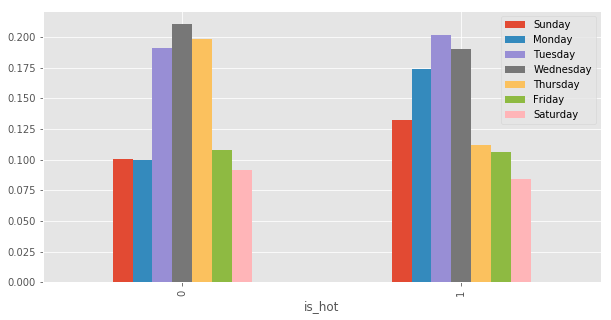

In [22]:
weekday_hot.plot(kind = 'bar',figsize = (10,5))

from above plot, we can see in Hot videos, the ones uploaded on Sunday and Monday occupy a higher ratio 
than Not Hot videos while the ones uploaded on Thursday occupy a lower ratio than Not Hot videos
. this may because these videos have longer "offline propagation time" than the ones uploaded at the second half
of the week.



Now let's check Language Impact

In [23]:
X.language.value_counts()

Cn       838
En       836
Other    606
Es       358
Fr        78
De        69
Name: language, dtype: int64

In [24]:
language_hot = X.groupby('is_hot').apply(lambda x:x.language.value_counts(normalize= True)).unstack()
language_hot

,Cn,De,En,Es,Fr,Other
is_hot,,,,,,
0,0.301094,0.027571,0.285339,0.131291,0.027133,0.227571
1,0.300000,0.012000,0.368000,0.116000,0.032000,0.172000


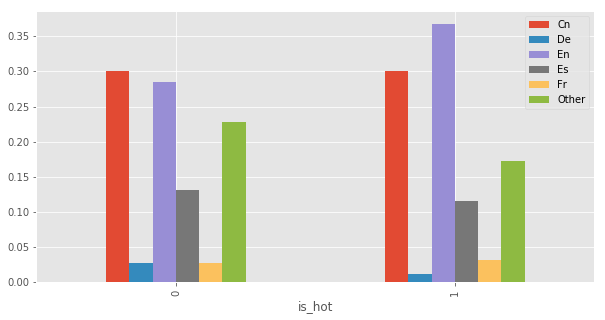

In [25]:
language_hot.plot(kind = 'bar',figsize= (10,5))


we can see vidoes in English occupies a higher ratio in Hot videos than in Not-Hot videos.

Use Decision Tree

In [26]:
y = X.is_hot
del X['is_hot']

In [27]:
X = pd.get_dummies(X,columns = ['language','weekday'])


In [28]:
X.head(5)
del X['language_Other']

In [29]:
dt = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
feat_importances = pd.Series(dt.feature_importances_,index = X.columns)
feat_importances.sort_values(ascending = False,inplace = True)
feat_importances

length               0.770395
language_En          0.080472
weekday_Thursday     0.069473
weekday_Monday       0.042372
quality              0.022493
weekday_Sunday       0.014795
weekday_Wednesday    0.000000
weekday_Tuesday      0.000000
weekday_Saturday     0.000000
weekday_Friday       0.000000
language_Fr          0.000000
language_Es          0.000000
language_De          0.000000
language_Cn          0.000000
dtype: float64

In [33]:
export_graphviz(dt,out_file="mytree.dot",feature_names = X.columns,class_names =['Not Hot','Hot'],proportion = True,
                leaves_parallel= True,filled=True)

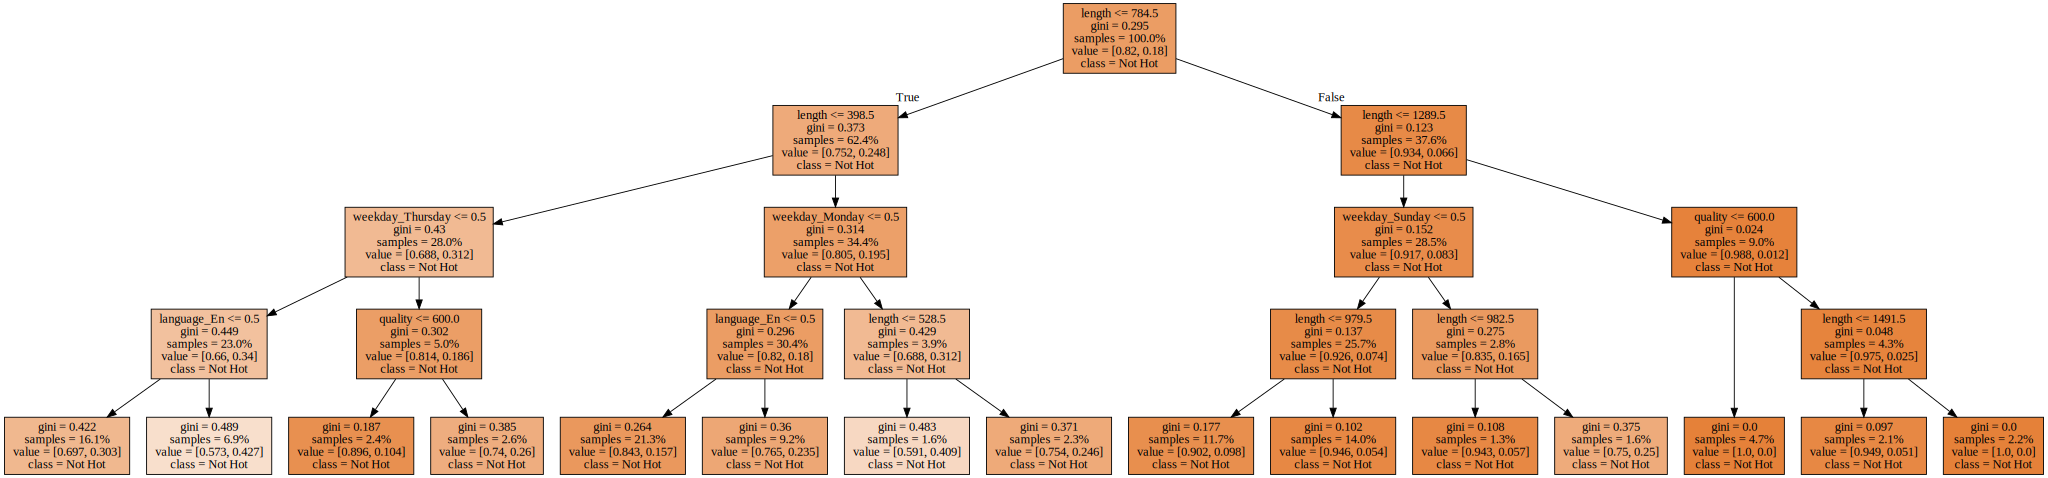

In [34]:
import graphviz
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

from above plot, focus on two leaves which have the highest "Hot" ratio

to reach the leave with Hot ratio=0.427 (2nd leave from left), the video must be
length < 398.5
Not uploaded on Thursday
English language
to reach the leave with Hot ratio=0.41 (7th leave from left), the video must be
Uploaded on Monday
length < 528.5

Main characters of Hot videos
according to above analysis, Hot vidoes should have following characteristics:

short videos is more likely to be Hot
videos uploaded at the first half of the week (Sunday, Monday) is more likely to be Hot than videos uploaded at the second half of the week (Thurday, etc)
videos in English is more likely to be Hot.


Answer question 3
After having identiﬁed the characteristics of the hot videos, how would you use this information from a product standpoint?

we can build a model to predict whether the video will be Hot (trending up) or not. The videos which are predicted to be Hot will be shown on the Home page and attract users to click.
study the reason why videos uploaded on Sunday/Monday are much more likely to be Hot than videos uploaded on Thursday.
if the reason is like my guess, is because Sunday/Monday allow the video have longer "offline propagation time"
then the problem is why "online propagation" doesn't work well?
Is it because our website doesn't have a "Share..." buttion?
or is it because we didn't include the most popular social network in our "Share with" list?
study the reason why English videos are more likely to be Hot.
is is because the translation issue?
or maybe we didn't include local social network (such as weibo in China) in our 'Share with' list.